In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(0, 1, 15)
train_y = torch.sin(train_x * (2 * math.pi))

In [3]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4)
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpectralMixtureGPModel(train_x, train_y, likelihood)

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.316
Iter 2/100 - Loss: 1.291
Iter 3/100 - Loss: 1.266
Iter 4/100 - Loss: 1.244
Iter 5/100 - Loss: 1.221
Iter 6/100 - Loss: 1.202
Iter 7/100 - Loss: 1.185
Iter 8/100 - Loss: 1.168
Iter 9/100 - Loss: 1.154
Iter 10/100 - Loss: 1.143
Iter 11/100 - Loss: 1.131
Iter 12/100 - Loss: 1.119
Iter 13/100 - Loss: 1.107
Iter 14/100 - Loss: 1.095
Iter 15/100 - Loss: 1.081
Iter 16/100 - Loss: 1.068
Iter 17/100 - Loss: 1.054
Iter 18/100 - Loss: 1.039
Iter 19/100 - Loss: 1.023
Iter 20/100 - Loss: 1.006
Iter 21/100 - Loss: 0.986
Iter 22/100 - Loss: 0.964
Iter 23/100 - Loss: 0.939
Iter 24/100 - Loss: 0.911
Iter 25/100 - Loss: 0.881
Iter 26/100 - Loss: 0.849
Iter 27/100 - Loss: 0.815
Iter 28/100 - Loss: 0.779
Iter 29/100 - Loss: 0.739
Iter 30/100 - Loss: 0.696
Iter 31/100 - Loss: 0.649
Iter 32/100 - Loss: 0.598
Iter 33/100 - Loss: 0.545
Iter 34/100 - Loss: 0.489
Iter 35/100 - Loss: 0.432
Iter 36/100 - Loss: 0.375
Iter 37/100 - Loss: 0.317
Iter 38/100 - Loss: 0.261
Iter 39/100 - Loss: 0

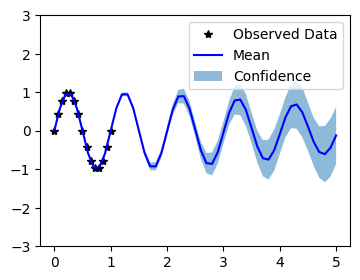

In [6]:
# Test points every 0.1 between 0 and 5
test_x = torch.linspace(0, 5, 51)

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Make predictions
    observed_pred = likelihood(model(test_x))

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])